# Modeling the Cell Cycle: Why Do Certain Circuits Oscillate?

### Simulation of 2D and 3D model of the cell cycle
#### James E. Ferrell's paper  DOI:https://doi.org/10.1016/j.cell.2011.03.006

In [1]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import fsolve
import pandas as pd

## Deterministic Three ODE Model of CDK1, Plk1, and APC Regulation

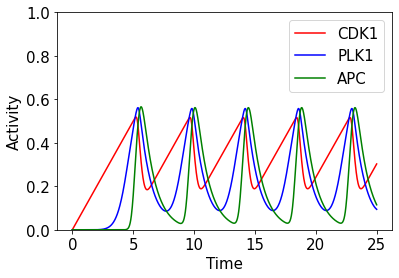

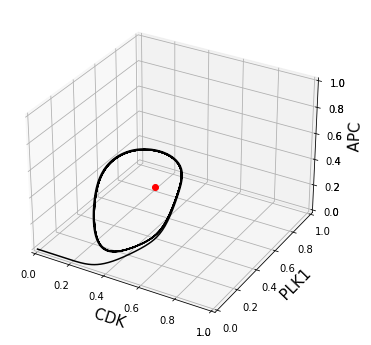

In [2]:
# Function for three ODE model of cell cycle
def cell_cycle_3d(x,t):
    CDK1 = x[0]
    PLK1 = x[1]
    APC = x[2]
    
    # ODES
    dCDK1dt = a1 - b1*CDK1*APC**n1/(K1**n1 + APC**n1)
    dPLK1dt = a2*(1-PLK1)*CDK1**n2/(K2**n2 + CDK1**n2) - b2*PLK1
    dAPCdt = a3*(1-APC)*PLK1**n3/(K3**n3 + PLK1**n3) - b3*APC
    
    return dCDK1dt,dPLK1dt,dAPCdt

#Parameters for the model
a1=0.1; a2=3; a3=3 # rate constants
b1=3; b2=1; b3=1 # rate constants
K1=0.5; K2=0.5; K3=0.5 # MM constants
n1=8; n2=8; n3=8 # Cooperativity

#Initial condition
init = [0,0,0]
#Time
t = np.linspace(0,25,1000)
#ODE
z = odeint(cell_cycle_3d,init,t)

#Plot
plt.plot(t,z[:,0],'r',label='CDK1')
plt.plot(t,z[:,1],'b',label='PLK1')
plt.plot(t,z[:,2],'g',label='APC')
#plt.title('Deterministic 3D Model of Cell Cycle')
plt.xlabel('Time',fontsize='15')
plt.ylabel('Activity',fontsize='15')
plt.ylim([0,1])
plt.legend(fontsize='15')
plt.xticks(fontsize='15')
plt.yticks(fontsize='15')
plt.show()

#Limit cycle

# Specify range of variables
npts= 100 # No. of points.
Cmin, Cmax= 0.1, 1.0 #CDK range
Amin, Amax= 0.1, 1.0 # APC range
CDK1= np.linspace(Cmin, Cmax, npts)
APC = np.linspace(Amin, Amax, npts)

# Function to solve 3D ODE to obtain solution
def Rss_3d(x):
    CDK1,PLK1,APC = x
    
    dCDK1dt = a1 - b1*CDK1*APC**n1/(K1**n1 + APC**n1)
    dPLK1dt = a2*(1-PLK1)*CDK1**n2/(K2**n2 + CDK1**n2) - b2*PLK1
    dAPCdt = a3*(1-APC)*PLK1**n3/(K3**n3 + PLK1**n3) - b3*APC
    return [dCDK1dt,dPLK1dt,dAPCdt]

#Plot Nullclines
CDK1_ss = a1/(b1*APC**n1/(K1**n1 + APC**n1))
Plk_ss = 1/ (1 + b2/(a2*CDK1_ss**n2/(K2**n2 + CDK1_ss**n2)))
APC_ss = 1/ (1 + b3/(a3*Plk_ss**n3/(K3**n3 + Plk_ss**n3)))

#Solving ODE for steady state solution
sol1= fsolve(Rss_3d, [0.5,0.5,0.5])
#print(sol1)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax = fig.add_subplot(111, projection='3d')

#Plot ODE dynamics
ax.plot3D(z[:,0],z[:,1],z[:,2],'k')
#Plot fixed point
ax.plot3D(sol1[0],sol1[1],sol1[2], 'ro',label='Fixed point')

ax.set_xlabel('  CDK',fontsize='15')
ax.set_ylabel('  PLK1',fontsize='15')
ax.set_zlabel('  APC',fontsize='15')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_zlim([0,1])
#ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

## Stochastic Three ODE  Model of CDK1, Plk1, and APC Regulation

In [3]:
# Function for stochastic simulation of 3D model of cell cycle
def stoc_cell_cycle_3d(Omega):
    #Parameters
    a1=0.1; a2=3; a3=3
    b1=3;   b2=1; b3=1
    K1=0.5; K2=0.5; K3=0.5
    n1=8;    n2=8;    n3=8
    #Empty list to store values
    n_CDK1 = []
    n_PLK1 = []
    n_APC = []
    time  = []
    T = 25 #Time
    t=0
    #Initial conditions
    CDK1 = 0.0
    PLK1 = 0.0
    APC = 0.0
    # Propensity
    V = Omega
    
    #Gillespie Algorithm
    while t<T:
        
        
        rates = [a1*V, b1*CDK1*APC**n1/((V*K1)**n1 + APC**n1),
                a2*(V-PLK1)*CDK1**n2/((V*K2)**n2 + CDK1**n2), b2*PLK1,
                a3*(V-APC)*PLK1**n3/((V*K3)**n3 + PLK1**n3), b3*APC]
        
        rate_sum = sum(rates)
        #Time step
        tau = -np.log(np.random.uniform(0,1))/rate_sum
        t+=tau     #time point of next event
        r = np.random.rand()*rate_sum
        
        #Select reactions
        
        #Production of CDK
        if(r>0 and r<rates[0]):
            CDK1 +=1
        #Degradation of CDK
        elif(r>rates[0] and r<sum(rates[0:2])):
            CDK1 -=1
        #Production of PLK
        elif(r>rates[1] and r<sum(rates[0:3])):
            PLK1 +=1
        #Degradation of PLK
        elif(r>rates[2] and r<sum(rates[0:4])):
            PLK1 -=1
        #Production of APC
        elif(r>rates[3] and r<sum(rates[0:5])):
            APC  +=1
        #Degradation of APC
        elif(r>rates[3] and r<sum(rates)):
            APC  -=1
        # DIviding by V for Normalization within 0-1.
        #Store at each time point
        time.append(t)
        n_CDK1.append(CDK1/V)
        n_PLK1.append(PLK1/V)
        n_APC.append(APC/V)
        
    return n_CDK1,n_PLK1,n_APC,time
    

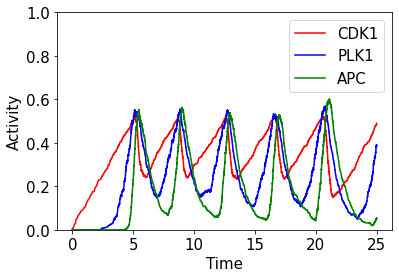

In [4]:
# Omega control random fluctuations in dynamics, low omega close to randomness, high omega closer to deterministic
Omega = 500 # vary omega (100-1000) 

# Perform stochastic simulation
CDK1,PLK1,APC,Time = stoc_cell_cycle_3d(Omega)

#Plot results
plt.plot(Time,CDK1,'r',label='CDK1')
plt.plot(Time,PLK1,'b',label='PLK1')
plt.plot(Time,APC,'g',label='APC')
#plt.title('Stochastic 3D Model of Cell cycle(Ω = %d)'%Omega)
plt.xlabel('Time',fontsize='15')
plt.ylabel('Activity',fontsize='15')
plt.ylim([0,1])
plt.yticks(fontsize='15')
plt.xticks(fontsize='15')
plt.legend(fontsize='15')
plt.show()

## Bifurcation plot for Three ODE Model

In [5]:
#Bifurcation data points obtained after simulating 3D model using AUTO in XppAut 
bf_data_b1 = pd.read_csv('cell_cycle_3d_hopf_b1.dat',sep='\s+',names=['X','Y','Z','P1','P2','P3'])
bf_data_b1.head()

,X,Y,Z,P1,P2,P3
0,0.030000,3.4739,3.4739,2,1,0
1,0.030349,3.4339,3.4339,1,1,0
2,0.030527,3.4139,3.4139,1,1,0
3,0.030707,3.3939,3.3939,1,1,0
4,0.030889,3.3739,3.3739,1,1,0


### Hopf Bifurcation

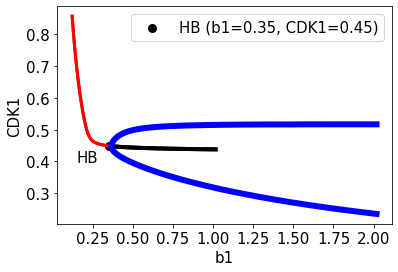

In [6]:
bf_kd1 = bf_data_b1[bf_data_b1['P1']==1]
bf_kd1

#Stable points
plt.plot(bf_kd1.X.loc[130:166],bf_kd1.Y.loc[130:166],'r',linewidth=3)
plt.plot(bf_kd1.X.loc[130:166],bf_kd1.Z.loc[130:166],'r',linewidth=3)
#Bifurcation points
plt.scatter(bf_kd1.X.loc[165],bf_kd1.Y.loc[165],color='k',label='HB (b1=%0.2f, CDK1=%.2f)'%(bf_kd1.X.loc[165],bf_kd1.Z.loc[165]) ,linewidth=3)
plt.text(bf_kd1.X.loc[165]-0.2,bf_kd1.Y.loc[165]-0.05,'HB',color='k',fontsize=15)

#Unstable points
bf_kd1 = bf_data_b1[bf_data_b1['P1']==2]
bf_kd1
#print(bf_kd1.shape)
plt.plot(bf_kd1.X.loc[166:199],bf_kd1.Y.loc[166:199],'k',linewidth=4)
plt.plot(bf_kd1.X.loc[166:199],bf_kd1.Z.loc[166:199],'k',linewidth=4)

#Bifurcation points
bf_kd1 = bf_data_b1[bf_data_b1['P1']==3]
bf_kd1
#print(bf_kd1.shape)
plt.plot(bf_kd1.X.loc[201:289],bf_kd1.Y.loc[201:289],'b',linewidth=6)
plt.plot(bf_kd1.X.loc[201:289],bf_kd1.Z.loc[201:289],'b',linewidth=6)


plt.ylabel('CDK1',fontsize=15)
plt.xlabel('b1',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

## Two Component Model of CDK1 and APC Regulation
#### Interlinked Positive and Negative Feedback Loops : Figure 8. Ferrell's paper

### Deterministic 2D Model

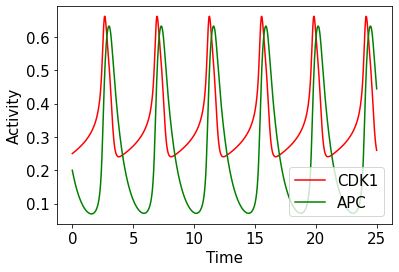

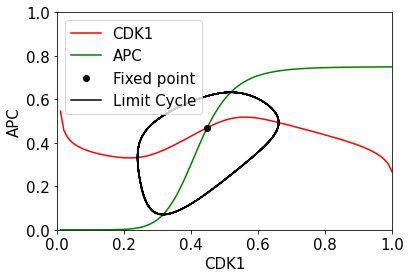

In [7]:
# Deterministic simulation of 2D cell cycle model
def bistable_trigger_2d(x,t):
    CDK1 = x[0]
    APC = x[1]
    # ODEs
    dCDK1dt = a1 - b1*CDK1*APC**n1/(K1**n1 + APC**n1) + a3*(1-CDK1)*CDK1**n3/(K3**n3 + CDK1**n3)
    dAPCdt = a2*(1-APC)*CDK1**n2/(K2**n2 + CDK1**n2)  - b2*APC
    
    return dCDK1dt,dAPCdt

#Parameters
a1 = 0.02; a2 = 3; a3 = 3 # rate constants
b1 = 3; b2 = 1 # rate constants
K1 = 0.5; K2 = 0.5; K3 = 0.5 # MM constants
n1 = 8; n2 = 8; n3 = 8 # Cooperativity

t = np.linspace(0,25,1000) #Time

# It init is zero, it takes time to start, if species already existing in it, then it fires rapidly.
init = [0.25,0.2]
# ODE Dynamics
z = odeint(bistable_trigger_2d, init,t)
#Plot    
plt.plot(t,z[:,0],'r',label='CDK1')
plt.plot(t,z[:,1],'g',label='APC')
#plt.title('2D Model Cell cycle Bistable Trigger')
plt.xlabel('Time',fontsize='15')
plt.ylabel('Activity',fontsize='15')
plt.yticks(fontsize='15')
plt.xticks(fontsize='15')
plt.legend(loc = 'lower right',fontsize='15')
plt.show()


def Rss(x):
    CDK1,APC = x
    
    dCDK1dt = a1 - b1*CDK1*APC**n1/(K1**n1 + APC**n1) + a3*(1-CDK1)*CDK1**n3/(K3**n3 + CDK1**n3)
    dAPCdt = a2*(1-APC)*CDK1**n2/(K2**n2 + CDK1**n2)  - b2*APC
    
    return [dCDK1dt,dAPCdt]


# Range of variables
npts= 100
Cmin, Cmax= 0.01, 1.0
Amin, Amax= 0.01, 1.0
CDK1= np.linspace(Cmin, Cmax, npts)
APC = np.linspace(Amin, Amax, npts)

#Null clines
APC_ss = 1/(1 + b2/(a2*CDK1**n2/(K2**n2 + CDK1**n2)))
APC_n1 = (a1+a3*(1-CDK1)*CDK1**n3/(K3**n3 + CDK1**n3))/(b1*CDK1)*(K1**n1)/(1 - (a1+a3*(1-CDK1)*CDK1**n3/(K3**n3 + CDK1**n3))/(b1*CDK1))
CDK_ss = np.power(APC_n1,1/n1)

# Plot nullclines
plt.plot(CDK1,CDK_ss,'r',label='CDK1')
plt.plot(CDK1,APC_ss,'g',label='APC')

# Find steady-state solutions using an initial guess
sol1= fsolve(Rss, [0.5,0.5])
plt.plot(sol1[0],sol1[1], 'ko',label='Fixed point')


plt.plot(z[:,0],z[:,1],'k',label='Limit Cycle')
plt.xlim([0,1])
plt.ylim([0,1])
#plt.title('Stable Limit Cycle')
plt.xlabel('CDK1',fontsize='15')
plt.ylabel('APC',fontsize='15')
plt.yticks(fontsize='15')
plt.xticks(fontsize='15')
plt.legend(fontsize='15')
plt.show()


## Bifurcation plot for Two ODE Model

In [8]:
#Bifurcation data points obtained after simulating 3D model using AUTO in XppAut 
bf_data_b1_2d = pd.read_csv('cell_cycle_2d_b1.dat',sep='\s+',names=['X','Y','Z','P1','P2','P3'])
bf_data_b1_2d.head()

,X,Y,Z,P1,P2,P3
0,0.300000,0.917756,0.917756,2,1,0
1,0.338629,0.907374,0.907374,1,1,0
2,0.377312,0.897193,0.897193,1,1,0
3,0.454824,0.877400,0.877400,1,1,0
4,0.571422,0.849038,0.849038,1,1,0


### Hopf Bifurcation

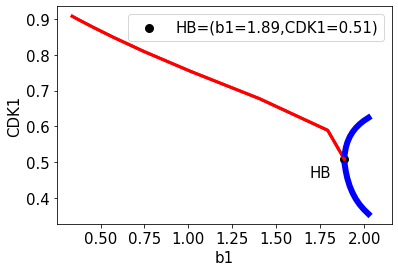

In [9]:
bf_kd1 = bf_data_b1_2d[bf_data_b1_2d['P1']==1]
bf_kd1

#Stable points
plt.plot(bf_kd1.X.loc[1:9],bf_kd1.Y.loc[1:9],'r',linewidth=3)
plt.plot(bf_kd1.X.loc[1:9],bf_kd1.Z.loc[1:9],'r',linewidth=3)
# Bifurcation point (HB)
plt.scatter(bf_kd1.X.loc[9],bf_kd1.Y.loc[9],color='k',label='HB=(b1=%0.2f,CDK1=%.2f)'%(bf_kd1.X.loc[9],bf_kd1.Z.loc[9]) ,linewidth=3)
plt.text(bf_kd1.X.loc[9]-0.2,bf_kd1.Y.loc[9]-0.05,'HB',color='k',fontsize=15)

bf_kd1 = bf_data_b1_2d[bf_data_b1_2d['P1']==2]
bf_kd1
#print(bf_kd1.shape)
plt.plot(bf_kd1.X.loc[10],bf_kd1.Y.loc[10],'k',linewidth=4)
plt.plot(bf_kd1.X.loc[10],bf_kd1.Z.loc[10],'k',linewidth=4)

#Bifurcation points
bf_kd1 = bf_data_b1_2d[bf_data_b1_2d['P1']==3]
bf_kd1
#print(bf_kd1.shape)
plt.plot(bf_kd1.X.loc[12:20],bf_kd1.Y.loc[12:20],'b',linewidth=6)
plt.plot(bf_kd1.X.loc[12:20],bf_kd1.Z.loc[12:20],'b',linewidth=6)

plt.ylabel('CDK1',fontsize=15)
plt.xlabel('b1',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()
